# Collaboration and Competition

---

This notebook is my solution to the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Import the needed packages and start the Tennis Unity Environment

Make sure you follow the setup described in the README of this repository before running the next cell.

In [1]:
import torch
import numpy as np
import pandas as pd
from collections import deque
from unityagents import UnityEnvironment
import random
import matplotlib.pyplot as plt
%matplotlib inline
from multi_ddpg_agent import MultiAgentController

env = UnityEnvironment(file_name="Tennis.app") 
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [2]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

The next code cell will run an untrained agent in the Environment.

In [3]:
for i in range(1, 5):                                      # play game for 4 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)    
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))
env.close()

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.09000000171363354


### 4. Train Multi Agent DDPG  to solve the environment

The next code cell will train a Multiple DDPG Agents until it gets 100 consecutive episodes that have an average score of over 0.5. After that is done, it will save the model weights in local files(checkpoint_actor_0.pth,  checkpoint_actor_1.pth, checkpoint_critic_0.pth and checkpoint_critic_1.pth) to be used later.

Episode 100	Current score: 0.00000	Average Score: 0.00100
Episode 200	Current score: 0.00000	Average Score: 0.00660
Episode 300	Current score: 0.10000	Average Score: 0.03490
Episode 400	Current score: 0.20000	Average Score: 0.09200
Episode 500	Current score: 0.10000	Average Score: 0.11990
Episode 600	Current score: 0.00000	Average Score: 0.07140
Episode 700	Current score: 0.09000	Average Score: 0.08870
Episode 800	Current score: 0.30000	Average Score: 0.11360
Episode 900	Current score: 0.00000	Average Score: 0.19870
Episode 982	Current score: 2.50000	Average Score: 0.51240
Environment solved in 882 episodes!	Average Score: 0.51240


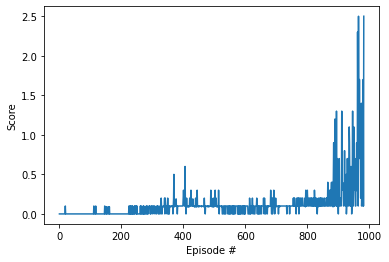

In [3]:
def ddpg(n_episodes=2000, max_t=1000, print_every=100):
    ma_controller = MultiAgentController(state_size=state_size, action_size=action_size, num_agents = num_agents, random_seed=71)
    scores_window = deque(maxlen=print_every)
    scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        ma_controller.reset()
        score = np.zeros(num_agents)
        for t in range(max_t):
            actions = ma_controller.act(states)
            
            env_info = env.step(actions)[brain_name]   
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            
            ma_controller.step(states, actions, rewards, next_states, dones)
            states = next_states
            score += rewards
            if np.any(dones):
                break 
        
        scores_window.append(np.max(score))
        scores.append(np.max(score))
        
        print('\rEpisode {}\tCurrent score: {:.5f}\tAverage Score: {:.5f}'.format(i_episode, np.max(score), np.mean(scores_window)), end="")
        if i_episode % print_every == 0:
            print('\rEpisode {}\tCurrent score: {:.5f}\tAverage Score: {:.5f}'.format(i_episode, np.max(score), np.mean(scores_window)))
        if np.mean(scores_window)>=0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.5f}'.format(i_episode-print_every, np.mean(scores_window)))
            ma_controller.save()
            break
            
    return scores

scores = ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5. Visualize the trained agent

The next code cell will run the previously trained agent in the Environment.

In [3]:
ma_controller = MultiAgentController(state_size=state_size, action_size=action_size, num_agents = num_agents, random_seed=71)

# load the weights from file
ma_controller.load()

for t in range(1, 5):           
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = ma_controller.act(states)                # select an action (for each agent)
        env_info = env.step(actions)[brain_name]           # send all actions to the environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))
env.close()

Total score (averaged over agents) this episode: 2.1950000328943133
Total score (averaged over agents) this episode: 0.0950000025331974
Total score (averaged over agents) this episode: 0.5950000090524554
Total score (averaged over agents) this episode: 0.1450000023469329
